# VAE–LSTM (ACN Data)

In [407]:
#set seeds for deterministic behavior (as much as possible)
import os
import random
import numpy as np
import tensorflow as tf

SEED = 42

def set_seed(seed: int = SEED):
    os.environ["PYTHONHASHSEED"] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)

set_seed(SEED)

## 1. Imports

In [408]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import mean_squared_error as mse

import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from tensorflow.keras.optimizers import *


## 2. Configuration

In [409]:
# Paths
DATA_PATH = "ACN_Data_2018_2019.csv"   # <-- change to your local path (recommended: data/dataset.csv)

# Train/test split
train_size = 0.8
val_split = 0.2

# Sequence settings
sequence_length = 24*7     # one week of hourly data       
missing_len = 24           # to deconstruct the sequence

# Masking NaNs
mask_value = -999.      

# Model/training 
nn_size = 32
BATCH_SIZE = 168         # one week of hourly data    
EPOCHS = 100
lr_value = 1e-3
latent_dim = 2           # to be able to plot in 2D easily

# Plotting only
seq_id_1 = 7000               # Select sequence number 7000
seq_id_2 = 2500               # Select sequence number 2500
id_seq = 11595                # sequence ID to test on


## 3. Data loading

### Read Data

In [410]:
df = pd.read_csv(DATA_PATH)
df['Date_Time'] = pd.to_datetime(df['Date_Time'])
df.drop_duplicates('Date_Time', inplace=True)
df.set_index('Date_Time', inplace=True)

print(df.shape)

(14280, 5)


In [ ]:
# insert missing dates (between Dec 15 2018 to Jan 1 2019)

df = df.reindex(pd.date_range(df.head(1).index[0], df.tail(1).index[0], freq='H'))

print(df.shape)

(14664, 5)


C:\Users\supya\AppData\Local\Temp\ipykernel_14184\1376186944.py:3: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df = df.reindex(pd.date_range(df.head(1).index[0], df.tail(1).index[0], freq='H'))


### Plot Traffic Sample

Text(0, 0.5, 'kWh per hour')

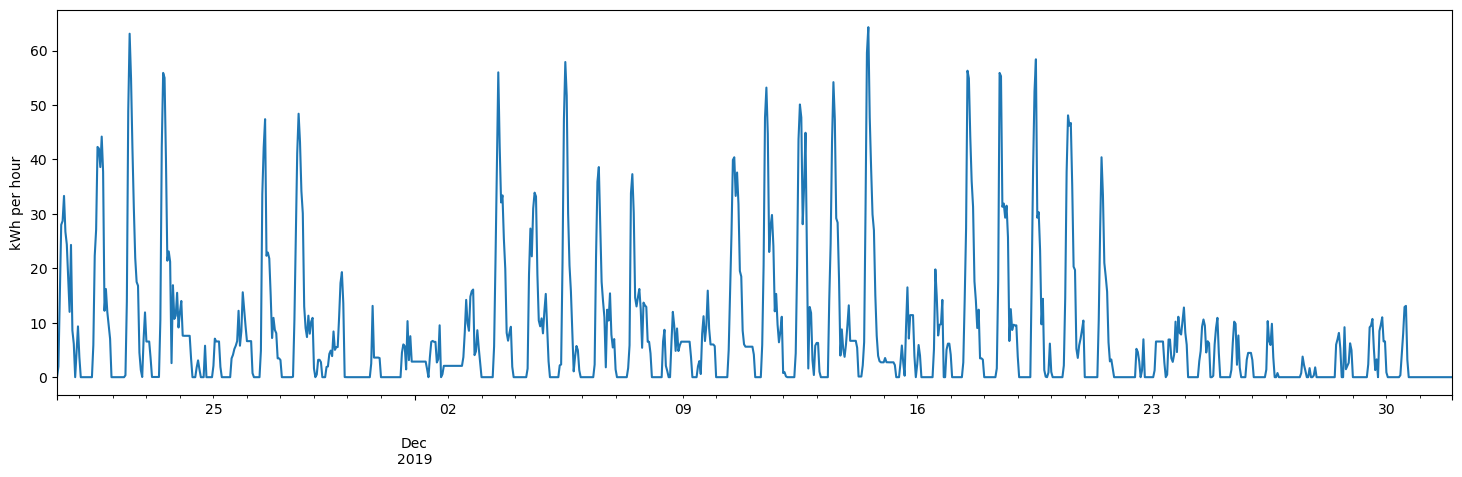

In [412]:
df.kWh_target.tail(1000).plot(figsize=(18,5))     #last 1000 samples without missing values
plt.ylabel('kWh per hour')

### Plot Missing Values Over Time

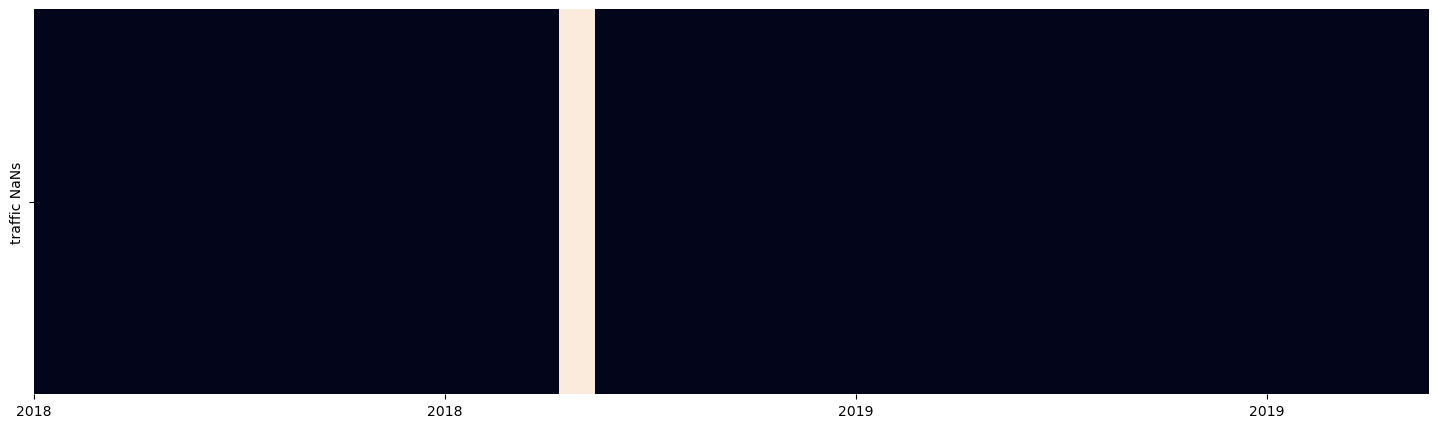

In [415]:
plt.figure(figsize=(18,5))
sns.heatmap(df[['kWh_target']].isna().T, cbar=False, 
            xticklabels=False, yticklabels=['traffic NaNs'])
plt.xticks(range(0,len(df), 24*180), list(df.index.year[::24*180]))  # a tick every 6 months (24 hours a day, 180 days)
np.set_printoptions(False)

### Fill Missing Values

In [399]:
df = df[df.index.year.isin([2018,2019])].copy()

print(df['Solar'].isnull().values.any())            # still with missing values 

True


In [400]:

df = pd.concat([df.select_dtypes(include=['object']).fillna(method='backfill'),
                df.select_dtypes(include=['float']).interpolate(method='time')], axis=1)

print(df.shape)


(14664, 5)


C:\Users\supya\AppData\Local\Temp\ipykernel_14184\1951520336.py:1: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = pd.concat([df.select_dtypes(include=['object']).fillna(method='backfill'),


### Plot Traffic Distribution In Each Month

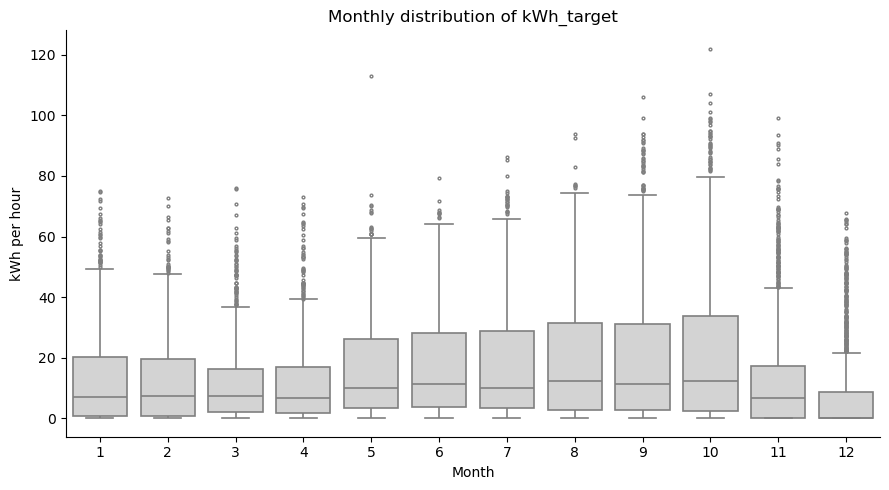

In [401]:
plt.figure(figsize=(9,5))

sns.boxplot(
    x=df.index.month,
    y=df.kWh_target,
    color="lightgray",
    linewidth=1.2,
    fliersize=2
)

plt.ylabel("kWh per hour")
plt.xlabel("Month")
plt.title("Monthly distribution of kWh_target")

sns.despine()
plt.tight_layout()
plt.show()

### Plot Traffic Distribution In Each Weekday

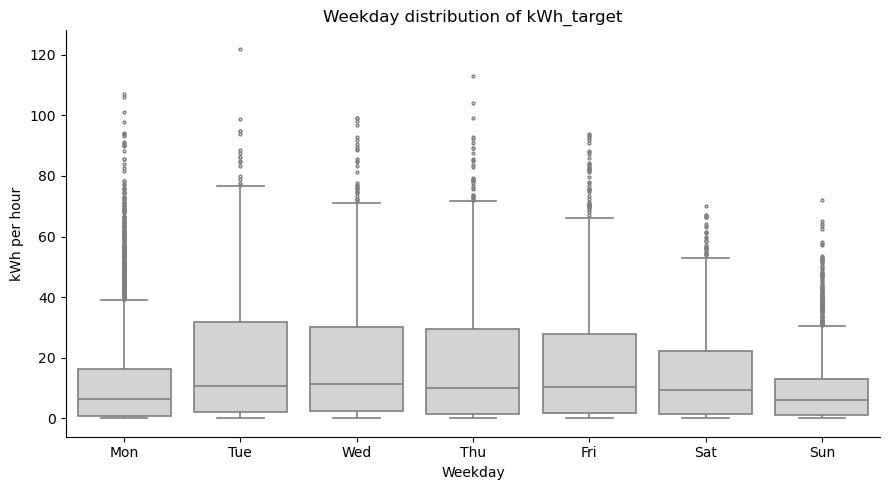

In [402]:
plt.figure(figsize=(9,5))

sns.boxplot(
    x=df.index.weekday,
    y=df.kWh_target,
    color="lightgray",
    linewidth=1.2,
    fliersize=2
)

weekday_labels = ["Mon", "Tue", "Wed", "Thu", "Fri", "Sat", "Sun"]
plt.xticks(range(7), weekday_labels)

plt.ylabel("kWh per hour")
plt.xlabel("Weekday")
plt.title("Weekday distribution of kWh_target")

sns.despine()
plt.tight_layout()
plt.show()

### Plot Traffic Distribution In Each Hour

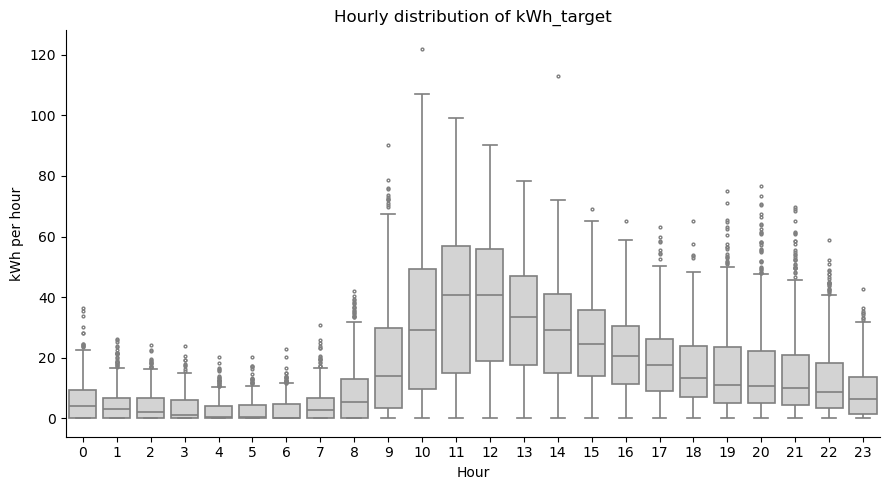

In [403]:
plt.figure(figsize=(9,5))

sns.boxplot(
    x=df.index.hour,
    y=df.kWh_target,
    color="lightgray",
    linewidth=1.2,
    fliersize=2
)

plt.ylabel("kWh per hour")
plt.xlabel("Hour")
plt.title("Hourly distribution of kWh_target")

sns.despine()
plt.tight_layout()
plt.show()

## 4. Data Preparation

### Function for Features Binning

In [362]:
CONT_COLS = ["Rain", "Temp", "Solar", "kWh_input"]

def make_train_bins_quantile(train_series, q):
    """
    Compute bin edges from TRAIN only.
    """
    s = train_series.dropna().astype(float)
    _, edges = pd.qcut(s, q=q, retbins=True, duplicates="drop")
    return edges

def apply_bins(series, edges):
    """
    Apply bin edges to full data.
    Output IDs:
        0 = missing
        1..K = bins
    """
    b = pd.cut(series.astype(float),
               bins=edges,
               labels=False,
               include_lowest=True)

    b = b.astype("float")
    b[series.isna()] = np.nan

    # missing -> 0, bins -> 1..K
    b = b.fillna(-1).astype(int) + 1

    return b.astype("int32")

### Features Binning

In [363]:
split_idx = int((len(df) - sequence_length) * train_size)  

BIN_SPECS = {
    "Rain": 20,
    "Temp": 40,
    "Solar": 60,
    "kWh_input": 50,
}

bin_edges = {}
for col, q in BIN_SPECS.items():

    # compute edges using TRAIN ONLY
    edges = make_train_bins_quantile(
        df.iloc[:split_idx][col],
        q=q
    )

    bin_edges[col] = edges

    # add new column directly to df
    df[col + "_bin"] = apply_bins(df[col], edges)

df.drop(columns=CONT_COLS, inplace=True)

In [364]:
# Check

for col in BIN_SPECS:
    bcol = col + "_bin"
    print(
        bcol,
        "min:", df[bcol].min(),
        "max:", df[bcol].max(),
        "dtype:", df[bcol].dtype
    )

Rain_bin min: 1 max: 3 dtype: int32
Temp_bin min: 1 max: 36 dtype: int32
Solar_bin min: 1 max: 35 dtype: int32
kWh_input_bin min: 1 max: 44 dtype: int32


In [365]:
X = df.drop(columns=['kWh_target'])

print(df)

                     kWh_target  Rain_bin  Temp_bin  Solar_bin  kWh_input_bin
2018-04-30 00:00:00        4.61         1         6          1             29
2018-04-30 01:00:00        2.32         1         6          1             31
2018-04-30 02:00:00        2.32         1         6          1             29
2018-04-30 03:00:00        2.32         1         6          1             17
2018-04-30 04:00:00        2.32         1         6          1             12
...                         ...       ...       ...        ...            ...
2019-12-31 19:00:00        0.00         1        13          1              1
2019-12-31 20:00:00        0.00         1        11          1              1
2019-12-31 21:00:00        0.00         1         9          1              1
2019-12-31 22:00:00        0.00         1         8          1              1
2019-12-31 23:00:00        0.00         1         6          1              1

[14664 rows x 5 columns]


### Add Temporal Features

In [366]:
map_col = dict()
map_col = {'Rain_bin': 0, 'Temp_bin': 1, 'Solar_bin': 2, 'kWh_input_bin': 3}
i=3                                                              # 4 features infront 
X['month'] = df.index.month;  i += 1;  map_col['month'] = i
X['weekday'] = df.index.weekday;  i += 1;  map_col['weekday'] = i
X['hour'] = df.index.hour;  i += 1;  map_col['hour'] = i
print(X.shape)
print(X)

(14664, 7)
                     Rain_bin  Temp_bin  Solar_bin  kWh_input_bin  month  \
2018-04-30 00:00:00         1         6          1             29      4   
2018-04-30 01:00:00         1         6          1             31      4   
2018-04-30 02:00:00         1         6          1             29      4   
2018-04-30 03:00:00         1         6          1             17      4   
2018-04-30 04:00:00         1         6          1             12      4   
...                       ...       ...        ...            ...    ...   
2019-12-31 19:00:00         1        13          1              1     12   
2019-12-31 20:00:00         1        11          1              1     12   
2019-12-31 21:00:00         1         9          1              1     12   
2019-12-31 22:00:00         1         8          1              1     12   
2019-12-31 23:00:00         1         6          1              1     12   

                     weekday  hour  
2018-04-30 00:00:00        0     0  
20

### Function For 3D Sequence Generation

In [367]:
def gen_seq(id_df, seq_length, seq_cols):

    data_matrix =  id_df[seq_cols]
    num_elements = data_matrix.shape[0]

    for start, stop in zip(range(0, num_elements-seq_length, 1), range(seq_length, num_elements, 1)):
        
        yield data_matrix[stop-sequence_length:stop].values.reshape((-1,len(seq_cols)))

### Generate 3D Sequences

In [368]:
sequence_input = []
sequence_target = []

for seq in gen_seq(X, sequence_length, X.columns):
    sequence_input.append(seq)
    
for seq in gen_seq(df, sequence_length, ['kWh_target']):
    sequence_target.append(seq)
    
sequence_input = np.asarray(sequence_input)
sequence_target = np.asarray(sequence_target)

print(sequence_input.shape)
print(sequence_target.shape)

print(sequence_input[1])
print(sequence_target[1])

(14496, 168, 7)
(14496, 168, 1)
[[ 1  6  1 ...  4  0  1]
 [ 1  6  1 ...  4  0  2]
 [ 1  6  1 ...  4  0  3]
 ...
 [ 1  1  1 ...  5  6 22]
 [ 1  1  1 ...  5  6 23]
 [ 1  1  1 ...  5  0  0]]
[[ 2.]
 [ 2.]
 [ 2.]
 [ 2.]
 [ 2.]
 [ 1.]
 [ 6.]
 [10.]
 [26.]
 [48.]
 [49.]
 [73.]
 [34.]
 [26.]
 [21.]
 [24.]
 [18.]
 [ 9.]
 [24.]
 [21.]
 [12.]
 [ 9.]
 [ 6.]
 [ 4.]
 [ 3.]
 [ 3.]
 [ 3.]
 [ 3.]
 [ 3.]
 [ 3.]
 [ 9.]
 [18.]
 [29.]
 [42.]
 [56.]
 [48.]
 [40.]
 [32.]
 [29.]
 [20.]
 [12.]
 [24.]
 [11.]
 [15.]
 [13.]
 [18.]
 [16.]
 [ 9.]
 [ 5.]
 [ 4.]
 [ 4.]
 [ 4.]
 [ 4.]
 [ 3.]
 [10.]
 [12.]
 [27.]
 [50.]
 [54.]
 [38.]
 [30.]
 [28.]
 [28.]
 [27.]
 [26.]
 [23.]
 [30.]
 [41.]
 [31.]
 [22.]
 [19.]
 [ 6.]
 [ 3.]
 [ 3.]
 [ 3.]
 [ 3.]
 [10.]
 [ 4.]
 [ 8.]
 [18.]
 [30.]
 [46.]
 [50.]
 [42.]
 [36.]
 [32.]
 [24.]
 [27.]
 [33.]
 [20.]
 [27.]
 [28.]
 [19.]
 [22.]
 [14.]
 [ 4.]
 [ 2.]
 [ 2.]
 [ 2.]
 [ 2.]
 [ 5.]
 [ 8.]
 [ 9.]
 [17.]
 [34.]
 [54.]
 [58.]
 [54.]
 [48.]
 [42.]
 [36.]
 [26.]
 [16.]
 [20.]
 [21.]
 [32.]


### Function To Insert Missing Intervals (Randomly)

In [369]:
def drop_fill_pieces(sequence_input, sequence_target, sequence_length, missing_len, map_col, missing_val=np.nan, size=0.6):
    
    sequence_input = np.copy(sequence_input)
    sequence_target = np.copy(sequence_target)
    
    _id_seq = np.random.choice(range(len(sequence_target)), int(len(sequence_target)*size), replace=False)
    _id_time = np.random.randint(0,sequence_length-missing_len, int(len(sequence_target)*size))
    
    for i,t in zip(_id_seq, _id_time):
        sequence_input[i, t:t+missing_len, 
                       [map_col['Rain_bin'], 
                        map_col['Temp_bin'],
                        map_col['Solar_bin']]] = -1
        sequence_target[i, t:t+missing_len, :] = missing_val
        
    sequence_input[:,:, 
                   [map_col['Rain_bin'], 
                    map_col['Temp_bin'],
                    map_col['Solar_bin']]] += 1
    
    return sequence_input, sequence_target

### Insert Missing Intervals (Randomly)

In [370]:

sequence_input, sequence_target_drop = drop_fill_pieces(sequence_input, sequence_target, sequence_length,
                                                        missing_len=missing_len, map_col=map_col, size=0.6)

sequence_input.shape, sequence_target_drop.shape

((14496, 168, 7), (14496, 168, 1))

In [371]:
# Index of missing values only in targets

aa = np.argwhere(np.isnan(sequence_target_drop))
aa[70:150] 
                                      

array([[  8,  72,   0],
       [  8,  73,   0],
       [ 10, 138,   0],
       [ 10, 139,   0],
       [ 10, 140,   0],
       [ 10, 141,   0],
       [ 10, 142,   0],
       [ 10, 143,   0],
       [ 10, 144,   0],
       [ 10, 145,   0],
       [ 10, 146,   0],
       [ 10, 147,   0],
       [ 10, 148,   0],
       [ 10, 149,   0],
       [ 10, 150,   0],
       [ 10, 151,   0],
       [ 10, 152,   0],
       [ 10, 153,   0],
       [ 10, 154,   0],
       [ 10, 155,   0],
       [ 10, 156,   0],
       [ 10, 157,   0],
       [ 10, 158,   0],
       [ 10, 159,   0],
       [ 10, 160,   0],
       [ 10, 161,   0],
       [ 12,   7,   0],
       [ 12,   8,   0],
       [ 12,   9,   0],
       [ 12,  10,   0],
       [ 12,  11,   0],
       [ 12,  12,   0],
       [ 12,  13,   0],
       [ 12,  14,   0],
       [ 12,  15,   0],
       [ 12,  16,   0],
       [ 12,  17,   0],
       [ 12,  18,   0],
       [ 12,  19,   0],
       [ 12,  20,   0],
       [ 12,  21,   0],
       [ 12,  22

### Train Test Split

In [372]:
sequence_input_train = sequence_input[:int(len(sequence_input)*train_size)]
sequence_input_test = sequence_input[int(len(sequence_input)*train_size):]
print(sequence_input_train.shape, sequence_input_test.shape)

sequence_target_train = sequence_target[:int(len(sequence_target)*train_size)]
sequence_target_test = sequence_target[int(len(sequence_target)*train_size):]
print(sequence_target_train.shape, sequence_target_test.shape)

sequence_target_drop_train = sequence_target_drop[:int(len(sequence_target_drop)*train_size)]
sequence_target_drop_test = sequence_target_drop[int(len(sequence_target_drop)*train_size):]
print(sequence_target_drop_train.shape, sequence_target_drop_test.shape)

(11596, 168, 7) (2900, 168, 7)
(11596, 168, 1) (2900, 168, 1)
(11596, 168, 1) (2900, 168, 1)


In [373]:
int(len(sequence_input)*train_size)

11596

### Class For Sequences Scaling

In [374]:
class Scaler1D:
    
    def fit(self, X):
        self.mean = np.nanmean(np.asarray(X).ravel())
        self.std = np.nanstd(np.asarray(X).ravel())
        return self
        
    def transform(self, X):
        return (X - self.mean)/self.std
    
    def inverse_transform(self, X):
        return (X*self.std) + self.mean

### Scale Sequences And Mask Nans

In [375]:
scaler_target = Scaler1D().fit(sequence_target_train)

sequence_target_train = scaler_target.transform(sequence_target_train)
sequence_target_test = scaler_target.transform(sequence_target_test)

sequence_target_drop_train = scaler_target.transform(sequence_target_drop_train)
sequence_target_drop_test = scaler_target.transform(sequence_target_drop_test)

sequence_target_drop_train[np.isnan(sequence_target_drop_train)] = mask_value
sequence_target_drop_test[np.isnan(sequence_target_drop_test)] = mask_value

In [376]:
# Checking

map_col.items()

dict_items([('Rain_bin', 0), ('Temp_bin', 1), ('Solar_bin', 2), ('kWh_input_bin', 3), ('month', 4), ('weekday', 5), ('hour', 6)])

## 5. Variational Autoencoder (VAE)

### Functions For VAE

In [377]:
# VAE Reparameterization (Samples a latent vector z from N(z_mean, sigma))
def sampling(args):
    
    z_mean, z_log_sigma = args
    batch_size = tf.shape(z_mean)[0]
    epsilon = K.random_normal(shape=(batch_size, latent_dim), mean=0., stddev=1.)
    
    return z_mean + K.exp(0.5 * z_log_sigma) * epsilon

# VAE Loss Function (Total loss = Reconstruction loss + KL divergence)
def vae_loss(inp, original, out, z_log_sigma, z_mean):
    
    reconstruction = K.mean(K.square(original - out)) * sequence_length
    kl = -0.5 * K.mean(1 + z_log_sigma - K.square(z_mean) - K.exp(z_log_sigma))

    return reconstruction + kl

# VAE Model
def get_model():
    
    set_seed(SEED)
    
    ### encoder ###
    inp = Input(shape=(sequence_length, 1))
    inp_original = Input(shape=(sequence_length, 1))
    
    cat_inp = []
    cat_emb = []
    for cat,i in map_col.items():
        inp_c = Input(shape=(sequence_length,))
        #inp_c = K.cast(inp_c,"int32")
        if cat in ['Rain_bin', 'Temp_bin', 'Solar_bin', 'kWh_input_bin']:
            emb = Embedding(int(X[cat].max()+2), 6)(inp_c)
        else:
            emb = Embedding(int(X[cat].max()+1), 6)(inp_c)
        cat_inp.append(inp_c)
        cat_emb.append(emb)
    
    concat = Concatenate()(cat_emb + [inp])
    #enc = LSTM(nn_size, return_sequences=True)(concat)
    enc = LSTM(nn_size)(concat)
    
    z = Dense(nn_size, activation="relu")(enc)
        
    z_mean = Dense(latent_dim)(z)
    z_log_sigma = Dense(latent_dim)(z)
            
    encoder = Model(cat_inp + [inp], [z_mean, z_log_sigma])
    
    ### decoder ###
    inp_z = Input(shape=(latent_dim,))

    dec = RepeatVector(sequence_length)(inp_z)
    dec = Concatenate()([dec] + cat_emb)
    #dec = LSTM(nn_size, return_sequences=True)(dec)
    dec = LSTM(4, return_sequences=True)(dec)
    
    out = TimeDistributed(Dense(1))(dec)
    
    decoder = Model([inp_z] + cat_inp, out)   
    
    ### encoder + decoder ###
    z_mean, z_log_sigma = encoder(cat_inp + [inp])
    z = Lambda(sampling)([z_mean, z_log_sigma])
    pred = decoder([z] + cat_inp)
    
    vae = Model(cat_inp + [inp, inp_original], pred)
    vae.add_loss(vae_loss(inp, inp_original, pred, z_log_sigma, z_mean))
    vae.compile(loss=None, optimizer=Adam(lr_value))
    
    return vae, encoder, decoder

### Model Training

In [378]:
es = EarlyStopping(patience=10, verbose=1, min_delta=0.001, monitor='loss', mode='auto', restore_best_weights=True)

vae, enc, dec = get_model()
vae.fit([sequence_input_train[:,:,i] for cat,i in map_col.items()] + [sequence_target_drop_train, sequence_target_train], 
         batch_size=BATCH_SIZE, epochs=EPOCHS, validation_split = val_split, shuffle=False, callbacks=[es])  


Epoch 1/100
56/56 [==============================] - 38s 611ms/step - loss: 180.5634 - val_loss: 100.2712
Epoch 2/100
56/56 [==============================] - 31s 559ms/step - loss: 146.2173 - val_loss: 63.8231
Epoch 3/100
56/56 [==============================] - 28s 500ms/step - loss: 100.2319 - val_loss: 53.6793
Epoch 4/100
56/56 [==============================] - 29s 511ms/step - loss: 77.8339 - val_loss: 47.6263
Epoch 5/100
56/56 [==============================] - 28s 505ms/step - loss: 79.0885 - val_loss: 60.7521
Epoch 6/100
56/56 [==============================] - 30s 543ms/step - loss: 67.8914 - val_loss: 83.1638
Epoch 7/100
56/56 [==============================] - 28s 509ms/step - loss: 61.1141 - val_loss: 76.6807
Epoch 8/100
56/56 [==============================] - 29s 511ms/step - loss: 58.2773 - val_loss: 68.0513
Epoch 9/100
56/56 [==============================] - 29s 513ms/step - loss: 56.0347 - val_loss: 68.9506
Epoch 10/100
56/56 [==============================] - 27s 48

### Compute Reconstruction

In [379]:
vae = Model(vae.input[:-1], vae.output)

reconstruc_train = scaler_target.inverse_transform(
    vae.predict([sequence_input_train[:,:,i] for cat,i in map_col.items()] + [sequence_target_drop_train]))
reconstruc_test = scaler_target.inverse_transform(
    vae.predict([sequence_input_test[:,:,i] for cat,i in map_col.items()] + [sequence_target_drop_test]))

reconstruc_train.shape, reconstruc_test.shape

91/91 [==============================] - 1s 12ms/step


((11596, 168, 1), (2900, 168, 1))

### Plot Real Vs Reconstruction

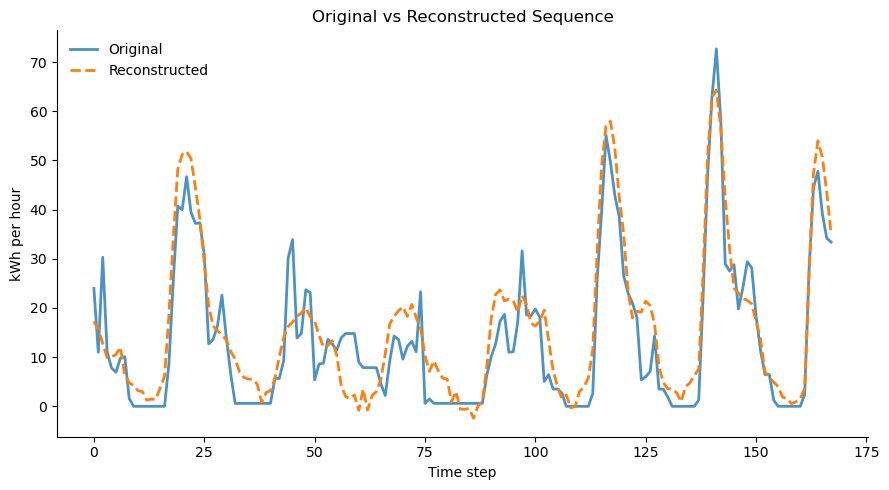

In [380]:
seq = np.copy(sequence_target_drop_train[seq_id_1])
seq[seq == mask_value] = np.nan
seq = scaler_target.inverse_transform(seq)

plt.figure(figsize=(9,5))

plt.plot(seq, label="Original", linewidth=2, alpha=0.8)
plt.plot(reconstruc_train[seq_id_1],
         label="Reconstructed",
         linewidth=2,
         linestyle="--")

plt.ylabel("kWh per hour")
plt.xlabel("Time step")
plt.title("Original vs Reconstructed Sequence")

plt.legend(frameon=False)
sns.despine()
plt.tight_layout()
plt.show()

### Plot Real Vs Reconstruction

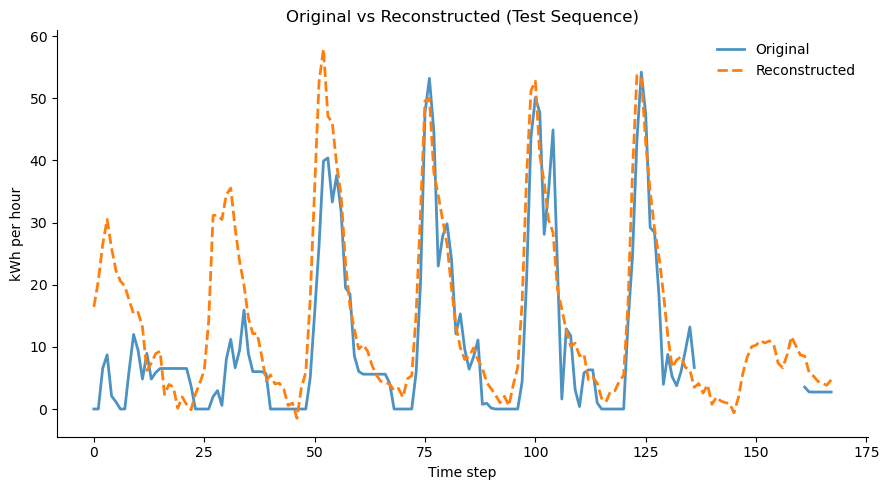

In [381]:
seq = np.copy(sequence_target_drop_test[seq_id_2])
seq[seq == mask_value] = np.nan
seq = scaler_target.inverse_transform(seq)

plt.figure(figsize=(9,5))

plt.plot(
    seq,
    label="Original",
    linewidth=2,
    alpha=0.8
)

plt.plot(
    reconstruc_test[seq_id_2],
    label="Reconstructed",
    linewidth=2,
    linestyle="--"
)

plt.ylabel("kWh per hour")
plt.xlabel("Time step")
plt.title("Original vs Reconstructed (Test Sequence)")

plt.legend(frameon=False)
sns.despine()
plt.tight_layout()
plt.show()

### Compute Performances (On Training)

In [382]:
mask = (sequence_target_drop_train == mask_value)

print('reconstruction error on entire sequences:',
    mse(np.squeeze(reconstruc_train, -1), np.squeeze(sequence_target_train, -1), squared=False))
print('reconstruction error on missing sequences:',
    mse(reconstruc_train[mask].reshape(-1,missing_len), sequence_target_train[mask].reshape(-1,missing_len), squared=False))

reconstruction error on entire sequences: 28.078117884202346
reconstruction error on missing sequences: 27.94289868876494


### Compute Performances (On Testing)

In [383]:
mask = (sequence_target_drop_test == mask_value)

print('reconstruction error on entire sequences:',
    mse(np.squeeze(reconstruc_test, -1), np.squeeze(sequence_target_test, -1), squared=False))
print('reconstruction error on missing sequences:',
    mse(reconstruc_test[mask].reshape(-1,missing_len), sequence_target_test[mask].reshape(-1,missing_len), squared=False))

reconstruction error on entire sequences: 29.967701420775803
reconstruction error on missing sequences: 29.73936642788495


### Get Latent Representation On Train Data

In [384]:
enc_pred, _ = enc.predict([sequence_input_train[:,:,i] for cat,i in map_col.items()] + [sequence_target_drop_train])
enc_pred.shape

363/363 [==============================] - 3s 6ms/step


(11596, 2)

### Plot Latent Representation

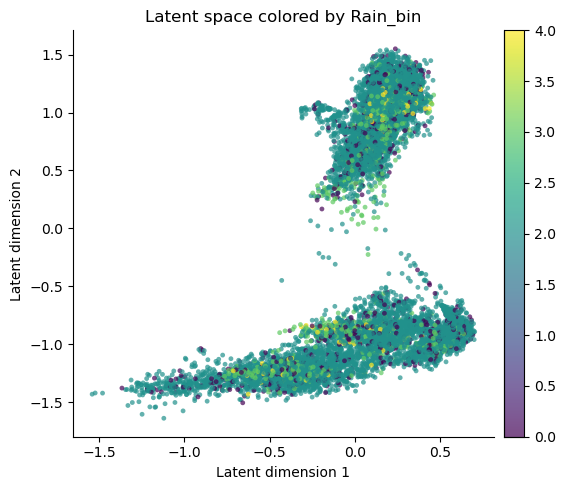

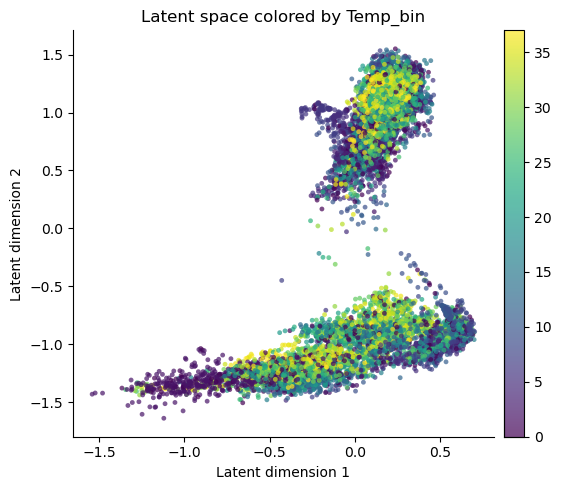

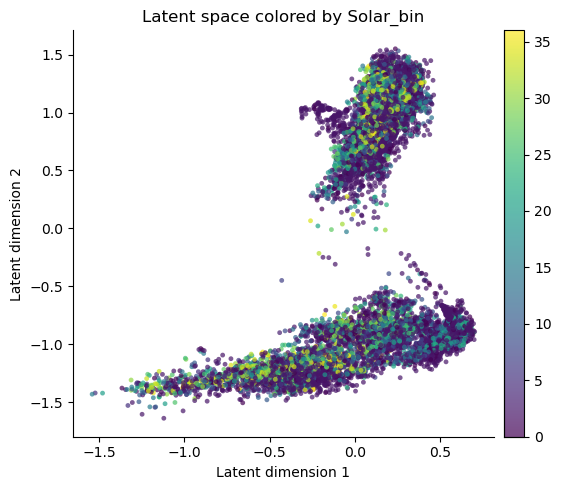

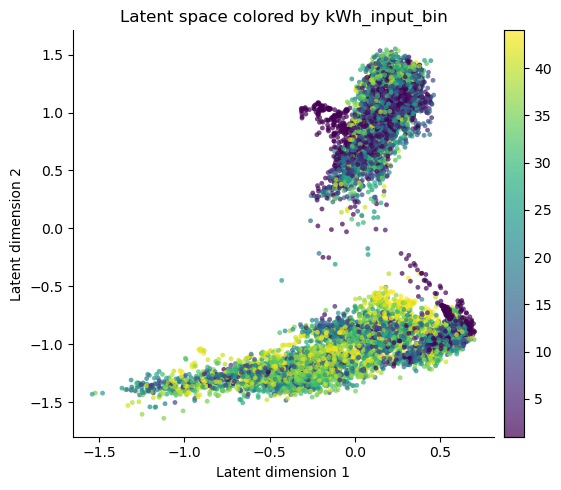

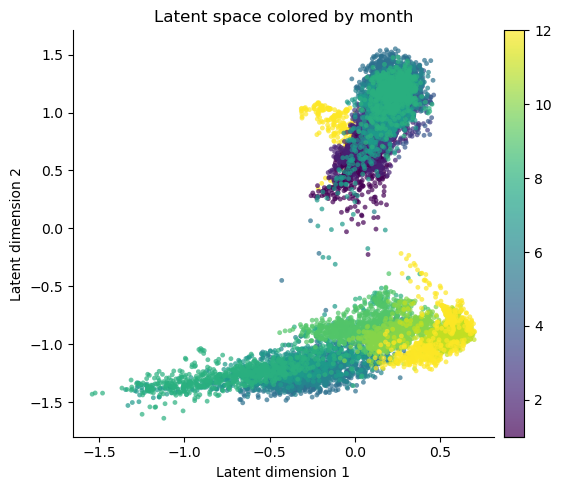

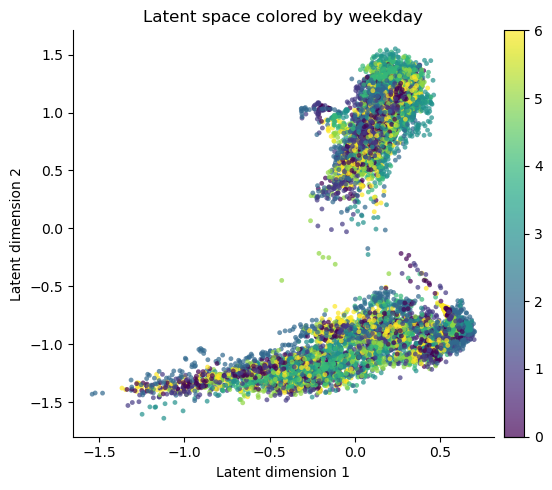

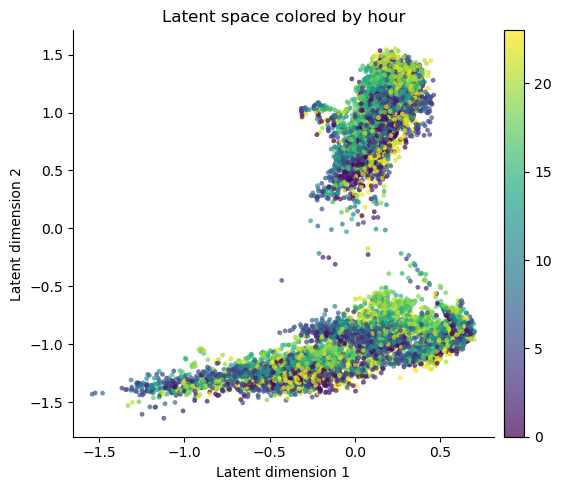

In [385]:
for cat, i in map_col.items():

    plt.figure(figsize=(6,5))

    sc = plt.scatter(
        enc_pred[:,0],
        enc_pred[:,1],
        c=sequence_input_train[:, sequence_length//2, i],
        s=12,
        alpha=0.7,
        linewidth=0
    )

    plt.xlabel("Latent dimension 1")
    plt.ylabel("Latent dimension 2")
    plt.title(f"Latent space colored by {cat}")

    plt.colorbar(sc, pad=0.02)
    sns.despine()
    plt.tight_layout()
    plt.show()

### Generate Random Permutation

In [386]:
_X = np.random.normal(enc_pred[id_seq,0], 3, 10)
_Y = np.random.normal(enc_pred[id_seq,1], 3, 10)
_cat_input = [sequence_input_train[[id_seq],:,i] for cat,i in map_col.items()]

In [387]:
# Checking

print(len(_cat_input))

aa = 0
for x in _X:
    for y in _Y:
        print(np.asarray([[x,y]]))
        aa = aa+1
aa        

7
[[ 5. -2.]]
[[5. 2.]]
[[ 5. -2.]]
[[ 5. -3.]]
[[5. 5.]]
[[5. 0.]]
[[5. 1.]]
[[ 5. -3.]]
[[ 5. -1.]]
[[5. 1.]]
[[ 2. -2.]]
[[2. 2.]]
[[ 2. -2.]]
[[ 2. -3.]]
[[2. 5.]]
[[2. 0.]]
[[2. 1.]]
[[ 2. -3.]]
[[ 2. -1.]]
[[2. 1.]]
[[-1. -2.]]
[[-1.  2.]]
[[-1. -2.]]
[[-1. -3.]]
[[-1.  5.]]
[[-1.  0.]]
[[-1.  1.]]
[[-1. -3.]]
[[-1. -1.]]
[[-1.  1.]]
[[ 2. -2.]]
[[2. 2.]]
[[ 2. -2.]]
[[ 2. -3.]]
[[2. 5.]]
[[2. 0.]]
[[2. 1.]]
[[ 2. -3.]]
[[ 2. -1.]]
[[2. 1.]]
[[-1. -2.]]
[[-1.  2.]]
[[-1. -2.]]
[[-1. -3.]]
[[-1.  5.]]
[[-1.  0.]]
[[-1.  1.]]
[[-1. -3.]]
[[-1. -1.]]
[[-1.  1.]]
[[-1. -2.]]
[[-1.  2.]]
[[-1. -2.]]
[[-1. -3.]]
[[-1.  5.]]
[[-1.  0.]]
[[-1.  1.]]
[[-1. -3.]]
[[-1. -1.]]
[[-1.  1.]]
[[ 1. -2.]]
[[1. 2.]]
[[ 1. -2.]]
[[ 1. -3.]]
[[1. 5.]]
[[1. 0.]]
[[1. 1.]]
[[ 1. -3.]]
[[ 1. -1.]]
[[1. 1.]]
[[-6. -2.]]
[[-6.  2.]]
[[-6. -2.]]
[[-6. -3.]]
[[-6.  5.]]
[[-6.  0.]]
[[-6.  1.]]
[[-6. -3.]]
[[-6. -1.]]
[[-6.  1.]]
[[-5. -2.]]
[[-5.  2.]]
[[-5. -2.]]
[[-5. -3.]]
[[-5.  5.]]
[[-5.  0.]]
[[-5. 

100

### Plot Random Permutation

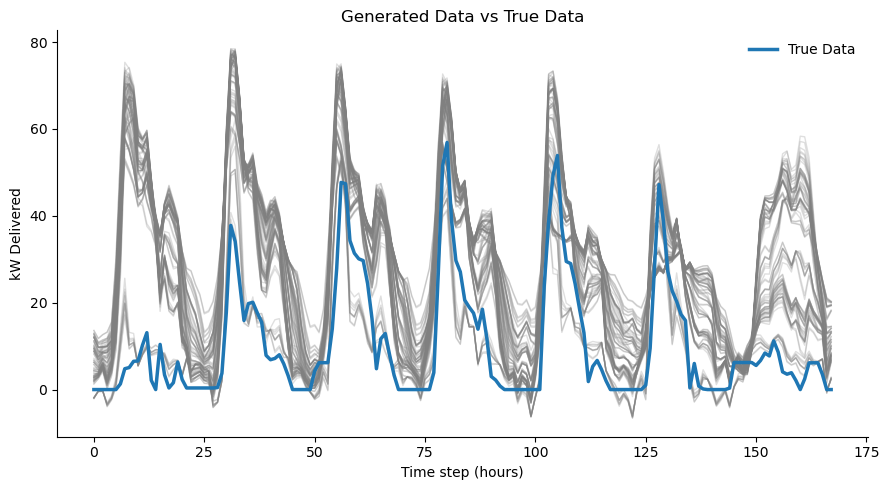

In [388]:
bb = 0
plt.figure(figsize=(9,5))

# generated samples (background)
for x in _X:
    for y in _Y:
        dec_pred = dec.predict(
            [np.asarray([[x, y]])] + _cat_input,
            verbose=0
        )

        plt.plot(
            scaler_target.inverse_transform(dec_pred[0]),
            color="gray",
            alpha=0.25,
            linewidth=1
        )

        bb += 1

# true sequence (foreground)
plt.plot(
    scaler_target.inverse_transform(sequence_target_train[id_seq]),
    linewidth=2.5,
    label="True Data"
)

plt.title("Generated Data vs True Data")
plt.ylabel("kW Delivered")
plt.xlabel("Time step (hours)")

plt.legend(frameon=False)
sns.despine()
plt.tight_layout()
plt.show()

In [389]:
# Checking 

print(dec_pred.size)
print(bb)

for cat in map_col:
    print(cat, X[cat].min(), X[cat].max(), X[cat].dtype)

168
100
Rain_bin 1 3 int32
Temp_bin 1 36 int32
Solar_bin 1 35 int32
kWh_input_bin 1 44 int32
month 1 12 int32
weekday 0 6 int32
hour 0 23 int32
